### Importing Necsessary Libraries

In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import geopandas as gpd
import contextily as ctx
from matplotlib.image import imread

### Loading Our data

In [2]:
DATA_PATH = (
    "../data/all-landsat-data.csv"  # Define the file path to the Landsat data CSV file
)
AOI_PATH = "../data/aoi.geojson"
df = pd.read_csv(
    "../data/all-landsat-data.csv", parse_dates=["date"]
)  # Read the CSV file into a DataFrame and parse the 'date' column as datetime

### Exploratory Data Analysis

In [3]:
# Area of Interest
SAVED_AOI_PATH = "../images/AOI/aoi_open_street_map.png"

✅ AOI map already exists — loading saved image...


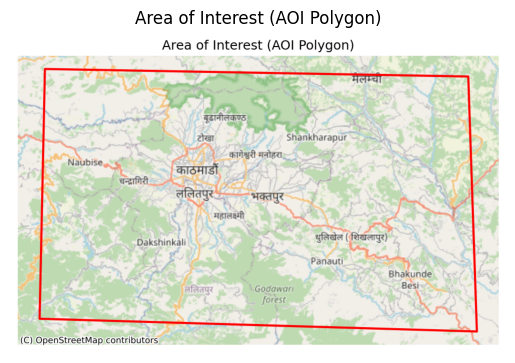

In [4]:
# --- Check if saved image exists ---
if os.path.exists(SAVED_AOI_PATH):
    print("✅ AOI map already exists — loading saved image...")
    img = imread(SAVED_AOI_PATH)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Area of Interest (AOI Polygon)")
    plt.show()

else:
    print("🗺️ Generating AOI map and saving it...")

    # Load AOI polygon from file
    gdf = gpd.read_file(AOI_PATH)

    # Ensure CRS is WGS84
    if gdf.crs is None:
        gdf.set_crs(epsg=4326, inplace=True)
    elif gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(epsg=4326)

    # Convert to Web Mercator for basemap
    gdf_web = gdf.to_crs(epsg=3857)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf_web.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title("Area of Interest (AOI Polygon)")
    ax.set_axis_off()

    # Save image
    os.makedirs(os.path.dirname(SAVED_AOI_PATH), exist_ok=True)
    plt.savefig(SAVED_AOI_PATH, bbox_inches="tight", dpi=150)
    plt.show()

    print(f"✅ AOI map saved to: {SAVED_AOI_PATH}")

In [5]:
df.head()

,date,NDVI_mean,NDVI_std,NDWI_mean,NDWI_std,NDBI_mean,NDBI_std,LST_mean_C,LST_std_C,count,year,scene
0,2022-01-27,0.201626,0.077391,0.055569,0.065216,-0.055569,0.065216,12.678688,4.144818,2649889,2022,January
1,2022-02-12,0.183799,0.099400,0.056023,0.066603,-0.056023,0.066603,13.168473,4.372898,2649889,2022,Feburary
2,2022-03-08,0.214993,0.070530,0.039716,0.068622,-0.039716,0.068622,25.446893,3.893588,2649889,2022,March
3,2022-04-17,0.243295,0.076340,0.059367,0.078458,-0.059367,0.078458,31.615345,4.400812,2649889,2022,April
4,2022-05-27,0.289823,0.087954,0.107981,0.066525,-0.107981,0.066525,27.281522,4.171977,2649889,2022,May


#### 1. NDVI (Vegetation Index)

In [6]:
NDVI_IMAGE_PARENT="../images/NDVI_PLOTS"
MEAN_OVER_TIME=os.path.join(NDVI_IMAGE_PARENT, "mot.png")
MULTI_YEAR_PLOT = os.path.join(NDVI_IMAGE_PARENT, "ndvi_over_years.png")
SEASONAL_PATTERN_FILE = os.path.join(NDVI_IMAGE_PARENT, "seasonal_pattern.png")

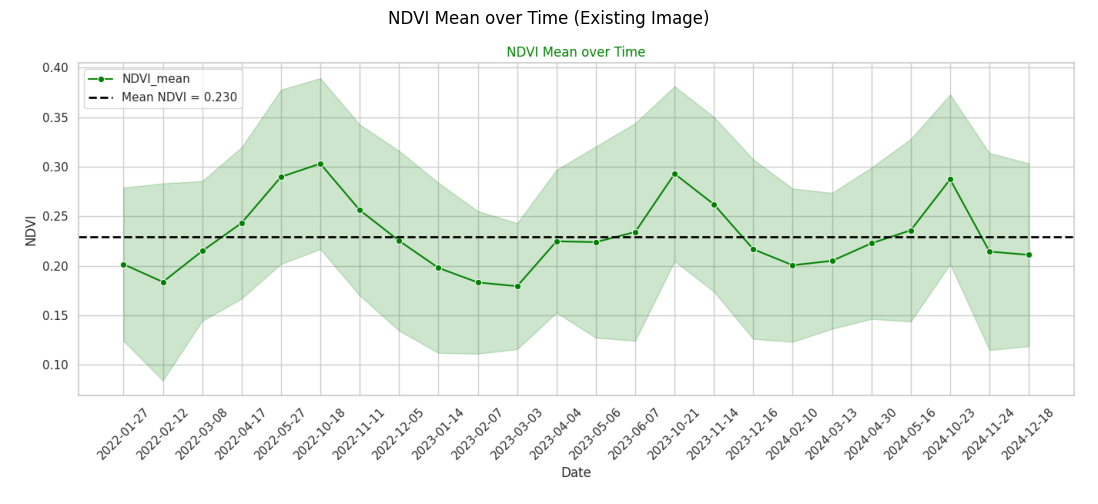

⚠️ File already exists: ../images/NDVI_PLOTS/mot.png, displaying image.


In [7]:
# IF-ELSE: Check if image already exists
if os.path.exists(MEAN_OVER_TIME):
    # Display the existing image
    img = imread(MEAN_OVER_TIME)
    plt.figure(figsize=(14, 6))
    plt.imshow(img)
    plt.axis("off")  # Hide axes
    plt.title("NDVI Mean over Time (Existing Image)")
    plt.show()
    print(f"⚠️ File already exists: {MEAN_OVER_TIME}, displaying image.")
else:
    # Create and save the plot
    sns.set_theme(style="whitegrid", palette="Greens")
    plt.figure(figsize=(14, 6))
    x_pos = np.arange(len(df))

    sns.lineplot(
        x=x_pos, y="NDVI_mean", data=df, marker="o", label="NDVI_mean", color="green"
    )

    plt.fill_between(
        x_pos,
        df["NDVI_mean"] - df["NDVI_std"],
        df["NDVI_mean"] + df["NDVI_std"],
        color="green",
        alpha=0.2,
    )

    mean_value = df["NDVI_mean"].mean()
    plt.axhline(
        mean_value,
        color="black",
        linestyle="--",
        linewidth=2,
        label=f"Mean NDVI = {mean_value:.3f}",
    )

    plt.title("NDVI Mean over Time", color="green")
    plt.xlabel("Date")
    plt.ylabel("NDVI")
    plt.grid(True)
    plt.xticks(x_pos, df["date"].dt.strftime("%Y-%m-%d"), rotation=45)
    plt.legend()
    plt.tight_layout()

    plt.savefig(MEAN_OVER_TIME)
    plt.show()
    print(f"✅ Saved plot as: {MEAN_OVER_TIME}")

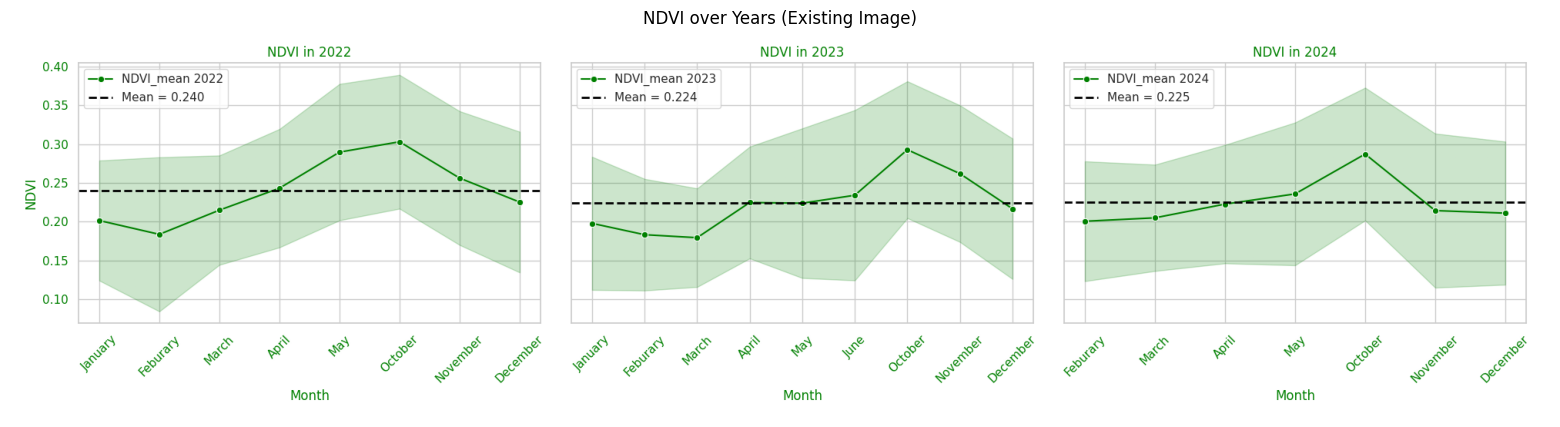

⚠️ File already exists: ../images/NDVI_PLOTS/ndvi_over_years.png, displaying image.


In [8]:
# IF-ELSE: check if image exists
if os.path.exists(MULTI_YEAR_PLOT):
    # Display existing image
    img = imread(MULTI_YEAR_PLOT)
    plt.figure(figsize=(20, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title("NDVI over Years (Existing Image)")
    plt.show()
    print(f"⚠️ File already exists: {MULTI_YEAR_PLOT}, displaying image.")
else:
    # Plotting
    sns.set_theme(style="whitegrid", palette="Greens")
    years = [2022, 2023, 2024]
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)  # 1 row, 3 columns

    for i, year in enumerate(years):
        df_year = df[df["year"] == year].reset_index(drop=True)
        ax = axes[i]

        # Line plot
        sns.lineplot(
            x=range(len(df_year)),
            y="NDVI_mean",
            data=df_year,
            marker="o",
            ax=ax,
            color="green",
            label=f"NDVI_mean {year}",
        )

        # Fill ± std
        ax.fill_between(
            range(len(df_year)),
            df_year["NDVI_mean"] - df_year["NDVI_std"],
            df_year["NDVI_mean"] + df_year["NDVI_std"],
            color="green",
            alpha=0.2,
        )

        # Mean line
        mean_value = df_year["NDVI_mean"].mean()
        ax.axhline(
            mean_value,
            color="black",
            linestyle="--",
            linewidth=2,
            label=f"Mean = {mean_value:.3f}",
        )

        # Titles and labels
        ax.set_title(f"NDVI in {year}", color="green")
        ax.set_xlabel("Month", color="green")
        if i == 0:
            ax.set_ylabel("NDVI", color="green")

        # X-axis labels
        ax.set_xticks(range(len(df_year)))
        ax.set_xticklabels(df_year["scene"], rotation=45, color="green")

        # Y-axis styling and grid
        ax.tick_params(axis="y", colors="green")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.savefig(MULTI_YEAR_PLOT)
    plt.show()
    print(f"✅ Saved multi-year NDVI plot as: {MULTI_YEAR_PLOT}")

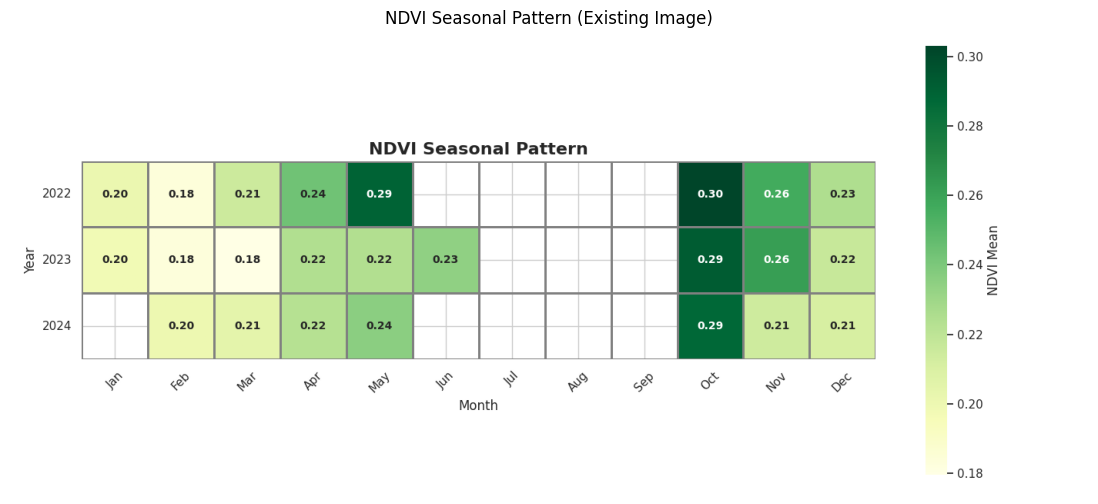

⚠️ File already exists: ../images/NDVI_PLOTS/seasonal_pattern.png, displaying image.


In [9]:
# IF-ELSE: check if image exists
if os.path.exists(SEASONAL_PATTERN_FILE):
    # Display existing image
    img = imread(SEASONAL_PATTERN_FILE)
    plt.figure(figsize=(14, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("NDVI Seasonal Pattern (Existing Image)")
    plt.show()
    print(f"⚠️ File already exists: {SEASONAL_PATTERN_FILE}, displaying image.")
else:
    # Extract month number if not already
    if "month_num" not in df.columns:
        df["month_num"] = df["date"].dt.month

    # Pivot table
    heatmap_df = df.pivot_table(index="year", columns="month_num", values="NDVI_mean")
    heatmap_df = heatmap_df.reindex(columns=range(1, 13))  # ensure all months

    # Plot heatmap
    plt.figure(figsize=(14, 6))
    sns.heatmap(
        heatmap_df,
        annot=True,
        fmt=".2f",
        cmap="YlGn",
        linewidths=1,
        linecolor="gray",
        square=True,
        cbar_kws={"label": "NDVI Mean"},
        annot_kws={"fontsize": 10, "fontweight": "bold"},
    )

    plt.xticks(
        ticks=np.arange(12) + 0.5,
        labels=[calendar.month_abbr[i] for i in range(1, 13)],
        rotation=45,
    )
    plt.yticks(rotation=0)
    plt.title("NDVI Seasonal Pattern", fontsize=16, fontweight="bold")
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Year", fontsize=12)
    plt.tight_layout()

    # Save and show
    plt.savefig(SEASONAL_PATTERN_FILE)
    plt.show()
    print(f"✅ Saved NDVI seasonal pattern heatmap as: {SEASONAL_PATTERN_FILE}")

#### 2. NDWI (Water Index)

In [10]:
NDWI_IMAGE_PARENT="../images/NDWI_PLOTS"
MEAN_OVER_TIME=os.path.join(NDWI_IMAGE_PARENT, "mot.png")
MULTI_YEAR_PLOT = os.path.join(NDWI_IMAGE_PARENT, "ndwi_over_years.png")
SEASONAL_PATTERN_FILE = os.path.join(NDWI_IMAGE_PARENT, "seasonal_pattern.png")

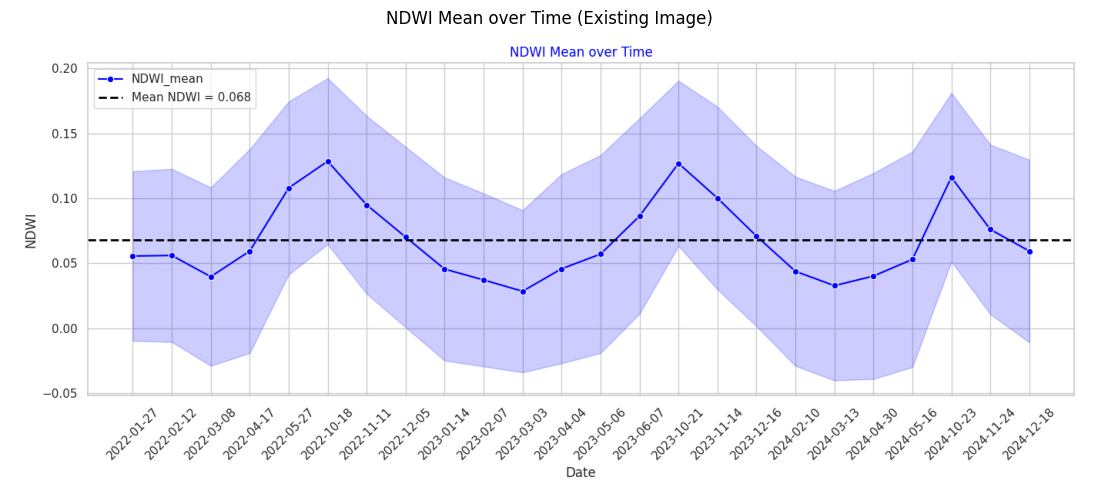

⚠️ File already exists: ../images/NDWI_PLOTS/mot.png, displaying image.


In [11]:
# IF-ELSE: check if image exists
if os.path.exists(MEAN_OVER_TIME):
    # Display existing image
    img = imread(MEAN_OVER_TIME)
    plt.figure(figsize=(14, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("NDWI Mean over Time (Existing Image)")
    plt.show()
    print(f"⚠️ File already exists: {MEAN_OVER_TIME}, displaying image.")
else:
    # Set blue theme
    sns.set_theme(style="whitegrid", palette="Blues")

    plt.figure(figsize=(14, 6))
    x_pos = np.arange(len(df))

    # Line plot
    sns.lineplot(
        x=x_pos, y="NDWI_mean", data=df, marker="o", label="NDWI_mean", color="blue"
    )

    # Fill ± std
    plt.fill_between(
        x_pos,
        df["NDWI_mean"] - df["NDWI_std"],
        df["NDWI_mean"] + df["NDWI_std"],
        color="blue",
        alpha=0.2,
    )

    # Mean line
    mean_value = df["NDWI_mean"].mean()
    plt.axhline(
        mean_value,
        color="black",
        linestyle="--",
        linewidth=2,
        label=f"Mean NDWI = {mean_value:.3f}",
    )

    plt.title("NDWI Mean over Time", color="blue")
    plt.xlabel("Date")
    plt.ylabel("NDWI")
    plt.grid(True)
    plt.xticks(x_pos, df["date"].dt.strftime("%Y-%m-%d"), rotation=45)
    plt.legend()
    plt.tight_layout()

    # Save and show
    plt.savefig(MEAN_OVER_TIME)
    plt.show()
    print(f"✅ Saved NDWI mean-over-time plot as: {MEAN_OVER_TIME}")

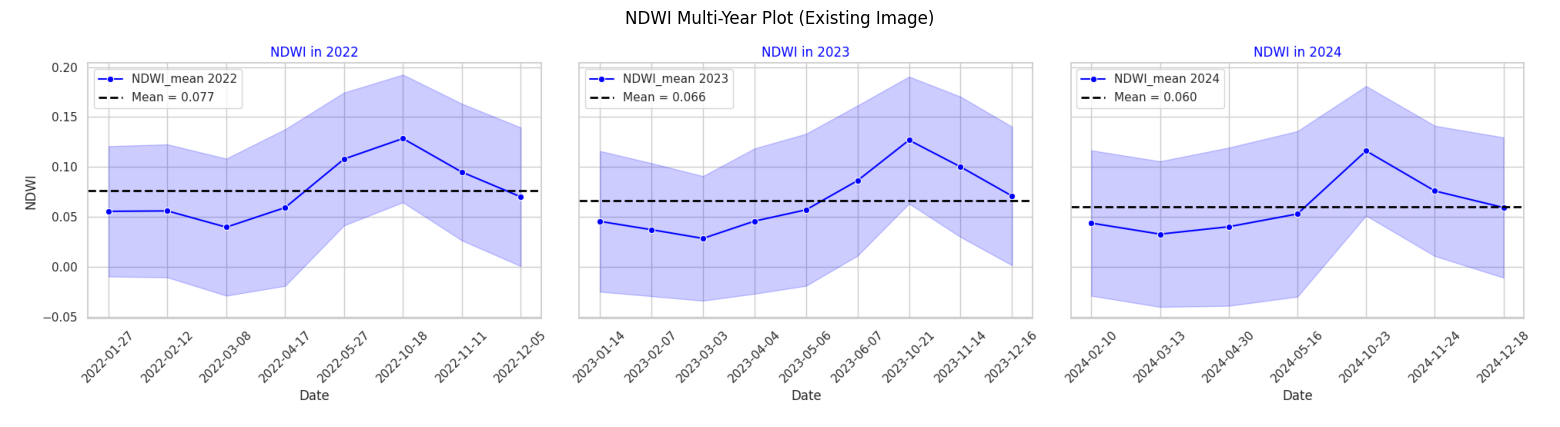

⚠️ File already exists: ../images/NDWI_PLOTS/ndwi_over_years.png, displaying image.


In [12]:
# IF-ELSE: check if image exists
if os.path.exists(MULTI_YEAR_PLOT):
    # Display existing image
    img = imread(MULTI_YEAR_PLOT)
    plt.figure(figsize=(20, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title("NDWI Multi-Year Plot (Existing Image)")
    plt.show()
    print(f"⚠️ File already exists: {MULTI_YEAR_PLOT}, displaying image.")
else:
    # Set blue theme
    sns.set_theme(style="whitegrid", palette="Blues")

    years = [2022, 2023, 2024]
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

    for i, year in enumerate(years):
        df_year = df[df["year"] == year].reset_index(drop=True)
        ax = axes[i]

        x_pos = np.arange(len(df_year))

        # Line plot
        sns.lineplot(
            x=x_pos,
            y="NDWI_mean",
            data=df_year,
            marker="o",
            ax=ax,
            color="blue",
            label=f"NDWI_mean {year}",
        )

        # Fill ± std
        ax.fill_between(
            x_pos,
            df_year["NDWI_mean"] - df_year["NDWI_std"],
            df_year["NDWI_mean"] + df_year["NDWI_std"],
            color="blue",
            alpha=0.2,
        )

        # Mean line
        mean_value = df_year["NDWI_mean"].mean()
        ax.axhline(
            mean_value,
            color="black",
            linestyle="--",
            linewidth=2,
            label=f"Mean = {mean_value:.3f}",
        )

        # Titles and labels
        ax.set_title(f"NDWI in {year}", color="blue")
        ax.set_xlabel("Date")
        if i == 0:
            ax.set_ylabel("NDWI")

        ax.set_xticks(x_pos)
        ax.set_xticklabels(df_year["date"].dt.strftime("%Y-%m-%d"), rotation=45)

        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.savefig(MULTI_YEAR_PLOT)
    plt.show()
    print(f"✅ Saved multi-year NDWI plot as: {MULTI_YEAR_PLOT}")

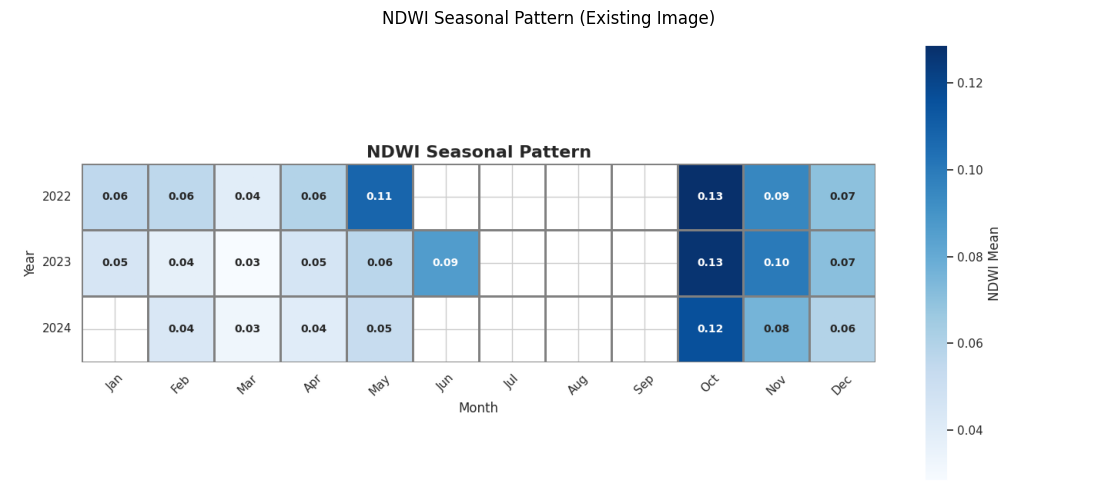

⚠️ File already exists: ../images/NDWI_PLOTS/seasonal_pattern.png, displaying image.


In [13]:
# IF-ELSE: check if image exists
if os.path.exists(SEASONAL_PATTERN_FILE):
    # Display existing image
    img = imread(SEASONAL_PATTERN_FILE)
    plt.figure(figsize=(14, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("NDWI Seasonal Pattern (Existing Image)")
    plt.show()
    print(f"⚠️ File already exists: {SEASONAL_PATTERN_FILE}, displaying image.")
else:
    # Ensure month column exists
    if "month_num" not in df.columns:
        df["month_num"] = df["date"].dt.month

    # Pivot table
    heatmap_df = df.pivot_table(index="year", columns="month_num", values="NDWI_mean")
    heatmap_df = heatmap_df.reindex(columns=range(1, 13))  # all months

    # Plot heatmap
    plt.figure(figsize=(14, 6))
    sns.heatmap(
        heatmap_df,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        linewidths=1,
        linecolor="gray",
        square=True,
        cbar_kws={"label": "NDWI Mean"},
        annot_kws={"fontsize": 10, "fontweight": "bold"},
    )

    plt.xticks(
        ticks=np.arange(12) + 0.5,
        labels=[calendar.month_abbr[i] for i in range(1, 13)],
        rotation=45,
    )
    plt.yticks(rotation=0)
    plt.title("NDWI Seasonal Pattern", fontsize=16, fontweight="bold")
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Year", fontsize=12)
    plt.tight_layout()

    # Save and show
    plt.savefig(SEASONAL_PATTERN_FILE)
    plt.show()
    print(f"✅ Saved NDWI seasonal pattern heatmap as: {SEASONAL_PATTERN_FILE}")

#### 3. NDBI (Built-up Index)

In [14]:
NDBI_IMAGE_PARENT="../images/NDBI_PLOTS"
MEAN_OVER_TIME=os.path.join(NDBI_IMAGE_PARENT, "mot.png")
MULTI_YEAR_PLOT = os.path.join(NDBI_IMAGE_PARENT, "ndbi_over_years.png")
SEASONAL_PATTERN_FILE = os.path.join(NDBI_IMAGE_PARENT, "seasonal_pattern.png")

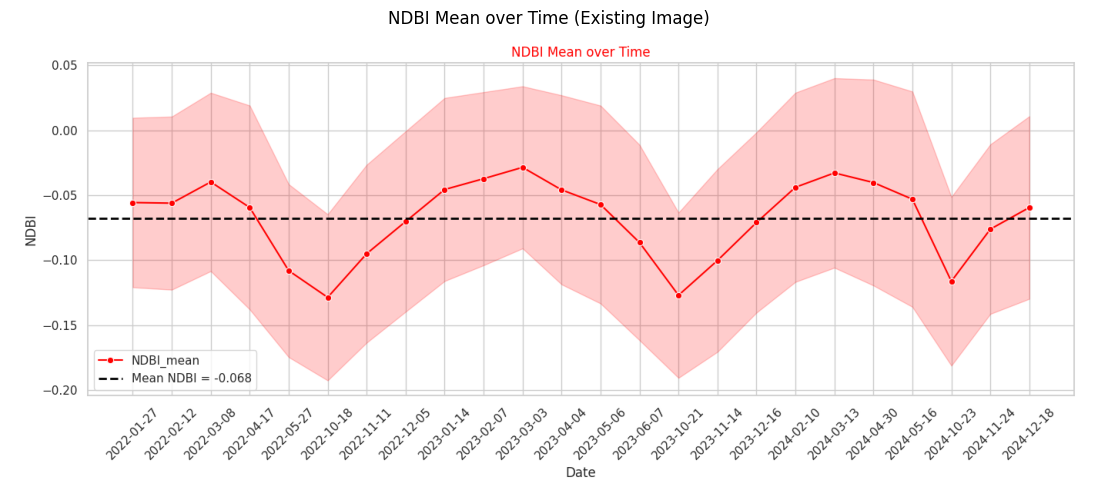

⚠️ File already exists: ../images/NDBI_PLOTS/mot.png, displaying image.


In [15]:
# IF-ELSE: check if image exists
if os.path.exists(MEAN_OVER_TIME):
    # Display existing image
    img = imread(MEAN_OVER_TIME)
    plt.figure(figsize=(14, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("NDBI Mean over Time (Existing Image)")
    plt.show()
    print(f"⚠️ File already exists: {MEAN_OVER_TIME}, displaying image.")
else:
    # Set red theme
    sns.set_theme(style="whitegrid", palette="Reds")

    plt.figure(figsize=(14, 6))
    x_pos = np.arange(len(df))

    # Line plot
    sns.lineplot(
        x=x_pos, y="NDBI_mean", data=df, marker="o", label="NDBI_mean", color="red"
    )

    # Fill ± std
    plt.fill_between(
        x_pos,
        df["NDBI_mean"] - df["NDBI_std"],
        df["NDBI_mean"] + df["NDBI_std"],
        color="red",
        alpha=0.2,
    )

    # Mean line
    mean_value = df["NDBI_mean"].mean()
    plt.axhline(
        mean_value,
        color="black",
        linestyle="--",
        linewidth=2,
        label=f"Mean NDBI = {mean_value:.3f}",
    )

    plt.title("NDBI Mean over Time", color="red")
    plt.xlabel("Date")
    plt.ylabel("NDBI")
    plt.grid(True)
    plt.xticks(x_pos, df["date"].dt.strftime("%Y-%m-%d"), rotation=45)
    plt.legend()
    plt.tight_layout()

    # Save and show
    plt.savefig(MEAN_OVER_TIME)
    plt.show()
    print(f"✅ Saved NDBI mean-over-time plot as: {MEAN_OVER_TIME}")

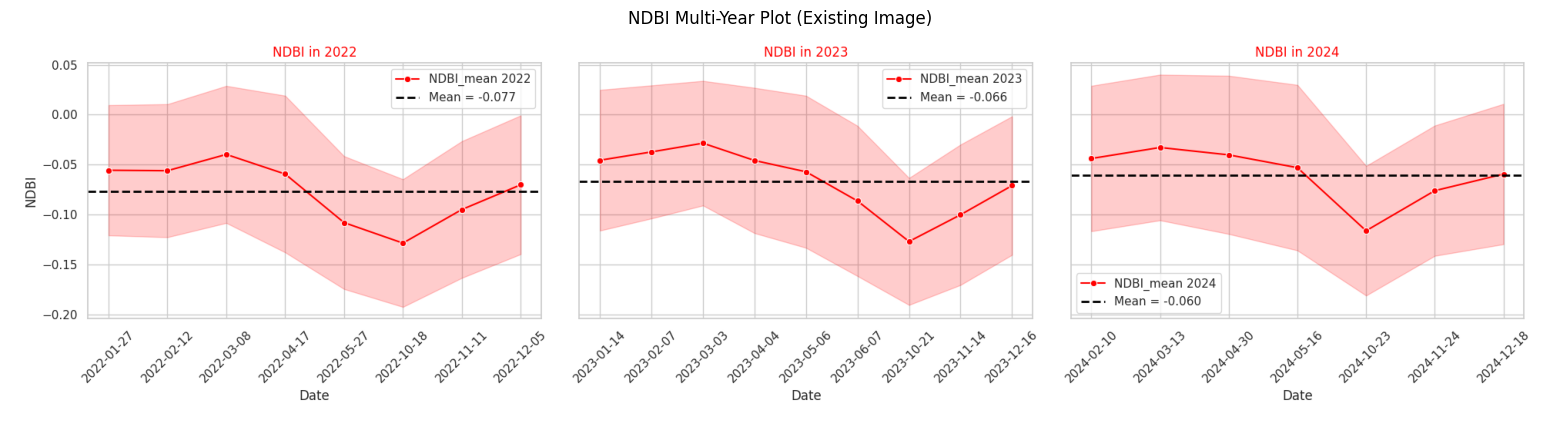

⚠️ File already exists: ../images/NDBI_PLOTS/ndbi_over_years.png, displaying image.


In [16]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.image import imread

# Paths
NDBI_IMAGE_PARENT = "../images/NDBI_PLOTS"
MULTI_YEAR_PLOT = os.path.join(NDBI_IMAGE_PARENT, "ndbi_over_years.png")

# Ensure folder exists
os.makedirs(NDBI_IMAGE_PARENT, exist_ok=True)

# IF-ELSE: check if image exists
if os.path.exists(MULTI_YEAR_PLOT):
    # Display existing image
    img = imread(MULTI_YEAR_PLOT)
    plt.figure(figsize=(20, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title("NDBI Multi-Year Plot (Existing Image)")
    plt.show()
    print(f"⚠️ File already exists: {MULTI_YEAR_PLOT}, displaying image.")
else:
    # Set red theme
    sns.set_theme(style="whitegrid", palette="Reds")

    years = [2022, 2023, 2024]
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

    for i, year in enumerate(years):
        df_year = df[df["year"] == year].reset_index(drop=True)
        ax = axes[i]

        x_pos = np.arange(len(df_year))

        # Line plot
        sns.lineplot(
            x=x_pos,
            y="NDBI_mean",
            data=df_year,
            marker="o",
            ax=ax,
            color="red",
            label=f"NDBI_mean {year}",
        )

        # Fill ± std
        ax.fill_between(
            x_pos,
            df_year["NDBI_mean"] - df_year["NDBI_std"],
            df_year["NDBI_mean"] + df_year["NDBI_std"],
            color="red",
            alpha=0.2,
        )

        # Mean line
        mean_value = df_year["NDBI_mean"].mean()
        ax.axhline(
            mean_value,
            color="black",
            linestyle="--",
            linewidth=2,
            label=f"Mean = {mean_value:.3f}",
        )

        # Titles and labels
        ax.set_title(f"NDBI in {year}", color="red")
        ax.set_xlabel("Date")
        if i == 0:
            ax.set_ylabel("NDBI")

        ax.set_xticks(x_pos)
        ax.set_xticklabels(df_year["date"].dt.strftime("%Y-%m-%d"), rotation=45)

        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.savefig(MULTI_YEAR_PLOT)
    plt.show()
    print(f"✅ Saved multi-year NDBI plot as: {MULTI_YEAR_PLOT}")

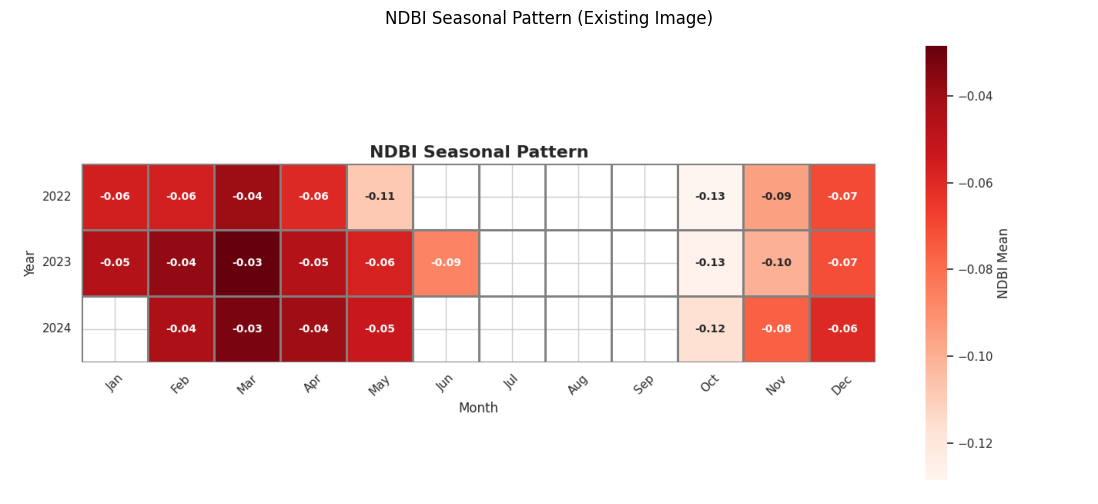

⚠️ File already exists: ../images/NDBI_PLOTS/seasonal_pattern.png, displaying image.


In [17]:
# IF-ELSE: check if image exists
if os.path.exists(SEASONAL_PATTERN_FILE):
    # Display existing image
    img = imread(SEASONAL_PATTERN_FILE)
    plt.figure(figsize=(14, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("NDBI Seasonal Pattern (Existing Image)")
    plt.show()
    print(f"⚠️ File already exists: {SEASONAL_PATTERN_FILE}, displaying image.")
else:
    # Ensure month column exists
    if "month_num" not in df.columns:
        df["month_num"] = df["date"].dt.month

    # Pivot table
    heatmap_df = df.pivot_table(index="year", columns="month_num", values="NDBI_mean")
    heatmap_df = heatmap_df.reindex(columns=range(1, 13))  # all months

    # Plot heatmap
    plt.figure(figsize=(14, 6))
    sns.heatmap(
        heatmap_df,
        annot=True,
        fmt=".2f",
        cmap="Reds",
        linewidths=1,
        linecolor="gray",
        square=True,
        cbar_kws={"label": "NDBI Mean"},
        annot_kws={"fontsize": 10, "fontweight": "bold"},
    )

    plt.xticks(
        ticks=np.arange(12) + 0.5,
        labels=[calendar.month_abbr[i] for i in range(1, 13)],
        rotation=45,
    )
    plt.yticks(rotation=0)
    plt.title("NDBI Seasonal Pattern", fontsize=16, fontweight="bold")
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Year", fontsize=12)
    plt.tight_layout()

    # Save and show
    plt.savefig(SEASONAL_PATTERN_FILE)
    plt.show()
    print(f"✅ Saved NDBI seasonal pattern heatmap as: {SEASONAL_PATTERN_FILE}")

#### 4. LST (Land Surface Temperature)

In [18]:
LST_IMAGE_PARENT="../images/LST_PLOTS"
MEAN_OVER_TIME=os.path.join(LST_IMAGE_PARENT, "mot.png")
MULTI_YEAR_PLOT = os.path.join(LST_IMAGE_PARENT, "lst_over_years.png")
SEASONAL_PATTERN_FILE = os.path.join(LST_IMAGE_PARENT, "seasonal_pattern.png")

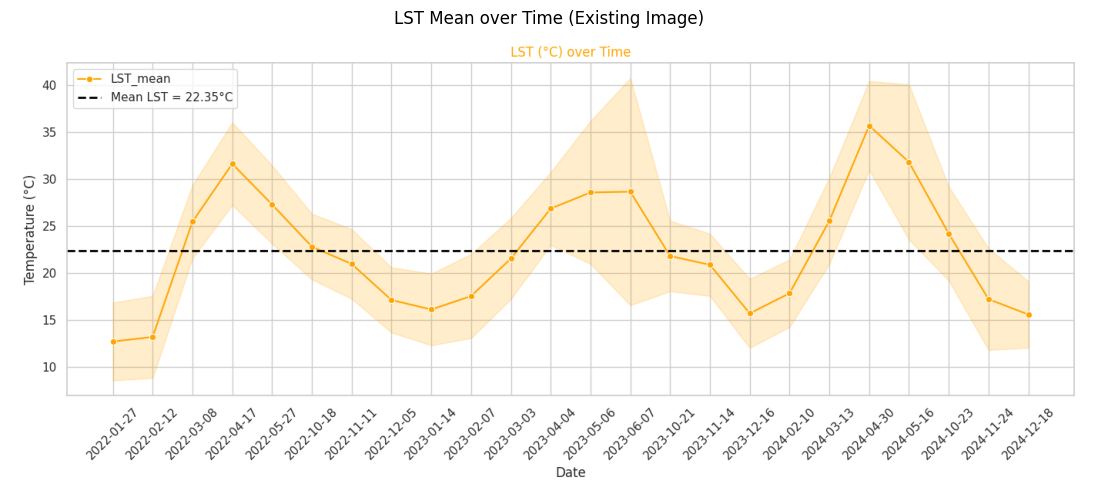

⚠️ File already exists: ../images/LST_PLOTS/mot.png, displaying image.


In [19]:
# IF-ELSE: check if image exists
if os.path.exists(MEAN_OVER_TIME):
    # Display existing image
    img = imread(MEAN_OVER_TIME)
    plt.figure(figsize=(14, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("LST Mean over Time (Existing Image)")
    plt.show()
    print(f"⚠️ File already exists: {MEAN_OVER_TIME}, displaying image.")
else:
    # Set orange theme
    sns.set_theme(style="whitegrid", palette="Oranges")

    plt.figure(figsize=(14, 6))
    x_pos = np.arange(len(df))

    # Line plot
    sns.lineplot(
        x=x_pos, y="LST_mean_C", data=df, marker="o", label="LST_mean", color="orange"
    )

    # Fill ± std
    plt.fill_between(
        x_pos,
        df["LST_mean_C"] - df["LST_std_C"],
        df["LST_mean_C"] + df["LST_std_C"],
        color="orange",
        alpha=0.2,
    )

    # Mean line
    mean_value = df["LST_mean_C"].mean()
    plt.axhline(
        mean_value,
        color="black",
        linestyle="--",
        linewidth=2,
        label=f"Mean LST = {mean_value:.2f}°C",
    )

    plt.title("LST (°C) over Time", color="orange")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.grid(True)
    plt.xticks(x_pos, df["date"].dt.strftime("%Y-%m-%d"), rotation=45)
    plt.legend()
    plt.tight_layout()

    # Save and show
    plt.savefig(MEAN_OVER_TIME)
    plt.show()
    print(f"✅ Saved LST mean-over-time plot as: {MEAN_OVER_TIME}")

- **`Extreme Seasonality:`** Shows a massive annual temperature swing, peaking in late spring/early summer (up to ≈35 ∘C) and bottoming in winter (≈15∘C).

- **`High Variability:`** The vast shaded area highlights extreme spatial temperature differences (e.g., 20∘C range in summer), indicating a mix of hot, exposed surfaces and cooler areas. 

- **`Warming Trend:`** The 2024 peak (≈35∘C) was significantly hotter than the 2023 peak (≈29∘C).

✅ LST shows a strong seasonal pattern, highest in April–May (pre-monsoon) and lowest in December–January (winter).

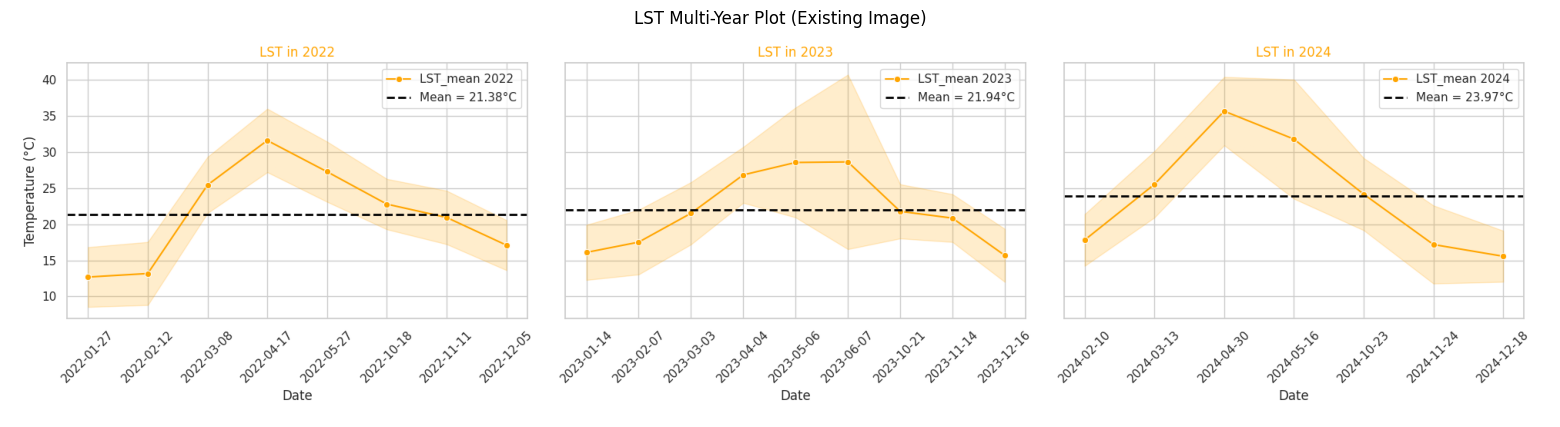

⚠️ File already exists: ../images/LST_PLOTS/lst_over_years.png, displaying image.


In [20]:
# IF-ELSE: check if image exists
if os.path.exists(MULTI_YEAR_PLOT):
    # Display existing image
    img = imread(MULTI_YEAR_PLOT)
    plt.figure(figsize=(20, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title("LST Multi-Year Plot (Existing Image)")
    plt.show()
    print(f"⚠️ File already exists: {MULTI_YEAR_PLOT}, displaying image.")
else:
    # Set orange theme
    sns.set_theme(style="whitegrid", palette="Oranges")

    years = [2022, 2023, 2024]
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

    for i, year in enumerate(years):
        df_year = df[df["year"] == year].reset_index(drop=True)
        ax = axes[i]

        x_pos = np.arange(len(df_year))

        # Line plot
        sns.lineplot(
            x=x_pos,
            y="LST_mean_C",
            data=df_year,
            marker="o",
            ax=ax,
            color="orange",
            label=f"LST_mean {year}",
        )

        # Fill ± std
        ax.fill_between(
            x_pos,
            df_year["LST_mean_C"] - df_year["LST_std_C"],
            df_year["LST_mean_C"] + df_year["LST_std_C"],
            color="orange",
            alpha=0.2,
        )

        # Mean line
        mean_value = df_year["LST_mean_C"].mean()
        ax.axhline(
            mean_value,
            color="black",
            linestyle="--",
            linewidth=2,
            label=f"Mean = {mean_value:.2f}°C",
        )

        # Titles and labels
        ax.set_title(f"LST in {year}", color="orange")
        ax.set_xlabel("Date")
        if i == 0:
            ax.set_ylabel("Temperature (°C)")

        ax.set_xticks(x_pos)
        ax.set_xticklabels(df_year["date"].dt.strftime("%Y-%m-%d"), rotation=45)

        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.savefig(MULTI_YEAR_PLOT)
    plt.show()
    print(f"✅ Saved multi-year LST plot as: {MULTI_YEAR_PLOT}")

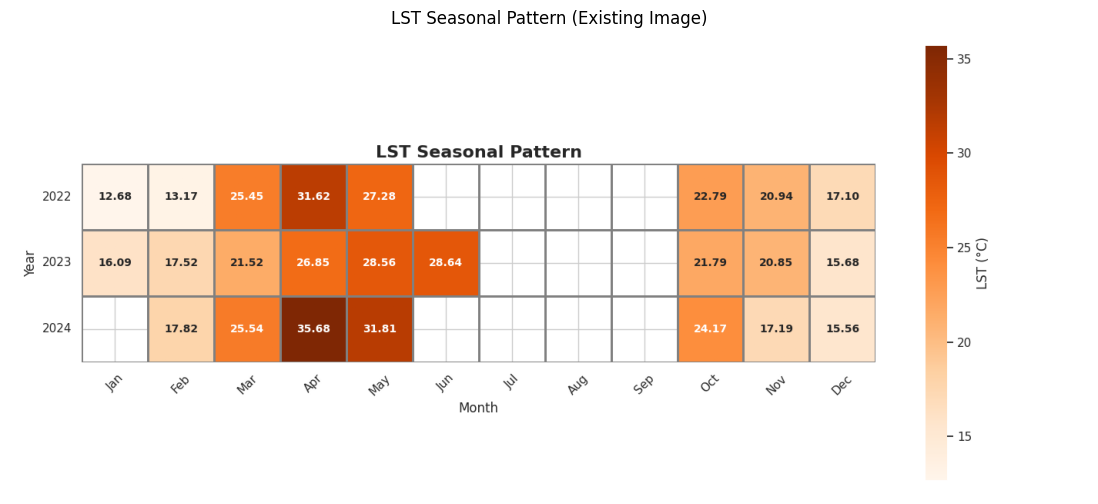

⚠️ File already exists: ../images/LST_PLOTS/seasonal_pattern.png, displaying image.


In [21]:
# IF-ELSE: check if image exists
if os.path.exists(SEASONAL_PATTERN_FILE):
    # Display existing image
    img = imread(SEASONAL_PATTERN_FILE)
    plt.figure(figsize=(14, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("LST Seasonal Pattern (Existing Image)")
    plt.show()
    print(f"⚠️ File already exists: {SEASONAL_PATTERN_FILE}, displaying image.")
else:
    # Ensure month column exists
    if "month_num" not in df.columns:
        df["month_num"] = df["date"].dt.month

    # Pivot table
    heatmap_df = df.pivot_table(index="year", columns="month_num", values="LST_mean_C")
    heatmap_df = heatmap_df.reindex(columns=range(1, 13))  # all months

    # Plot heatmap
    plt.figure(figsize=(14, 6))
    sns.heatmap(
        heatmap_df,
        annot=True,
        fmt=".2f",
        cmap="Oranges",
        linewidths=1,
        linecolor="gray",
        square=True,
        cbar_kws={"label": "LST (°C)"},
        annot_kws={"fontsize": 10, "fontweight": "bold"},
    )

    plt.xticks(
        ticks=np.arange(12) + 0.5,
        labels=[calendar.month_abbr[i] for i in range(1, 13)],
        rotation=45,
    )
    plt.yticks(rotation=0)
    plt.title("LST Seasonal Pattern", fontsize=16, fontweight="bold")
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Year", fontsize=12)
    plt.tight_layout()

    # Save and show
    plt.savefig(SEASONAL_PATTERN_FILE)
    plt.show()
    print(f"✅ Saved LST seasonal pattern heatmap as: {SEASONAL_PATTERN_FILE}")

#### 5. Correlation Analysis

In [22]:
COMBINED_IMAGE_PARENT="../images/COMBINED_PLOTS"
CORRELATION_MATRIX=os.path.join(COMBINED_IMAGE_PARENT, "corr.png")
YEARLY_CORRELATION_MATRIX=os.path.join(COMBINED_IMAGE_PARENT, "yearly_corr.png")

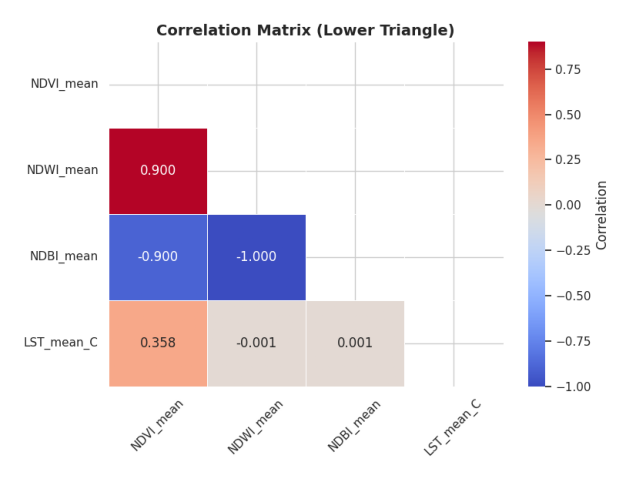

⚠️ File already exists: ../images/COMBINED_PLOTS/corr.png, displaying image.


In [23]:
# IF-ELSE: check if image already exists
if os.path.exists(CORRELATION_MATRIX):
    # Display existing image
    from matplotlib.image import imread
    img = imread(CORRELATION_MATRIX)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    print(f"⚠️ File already exists: {CORRELATION_MATRIX}, displaying image.")
else:
    # Compute correlation
    corr_df = df[["NDVI_mean", "NDWI_mean", "NDBI_mean", "LST_mean_C"]].corr()

    # Mask upper triangle
    mask = np.triu(np.ones_like(corr_df, dtype=bool))

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        corr_df,
        mask=mask,
        annot=True,
        fmt=".3f",
        cmap="coolwarm",
        linewidths=0.5,
        linecolor="white",
        cbar_kws={"label": "Correlation"},
    )
    plt.title("Correlation Matrix (Lower Triangle)", fontsize=14, weight="bold")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save image
    plt.savefig(CORRELATION_MATRIX)
    plt.show()
    print(f"✅ Correlation matrix saved at: {CORRELATION_MATRIX}")

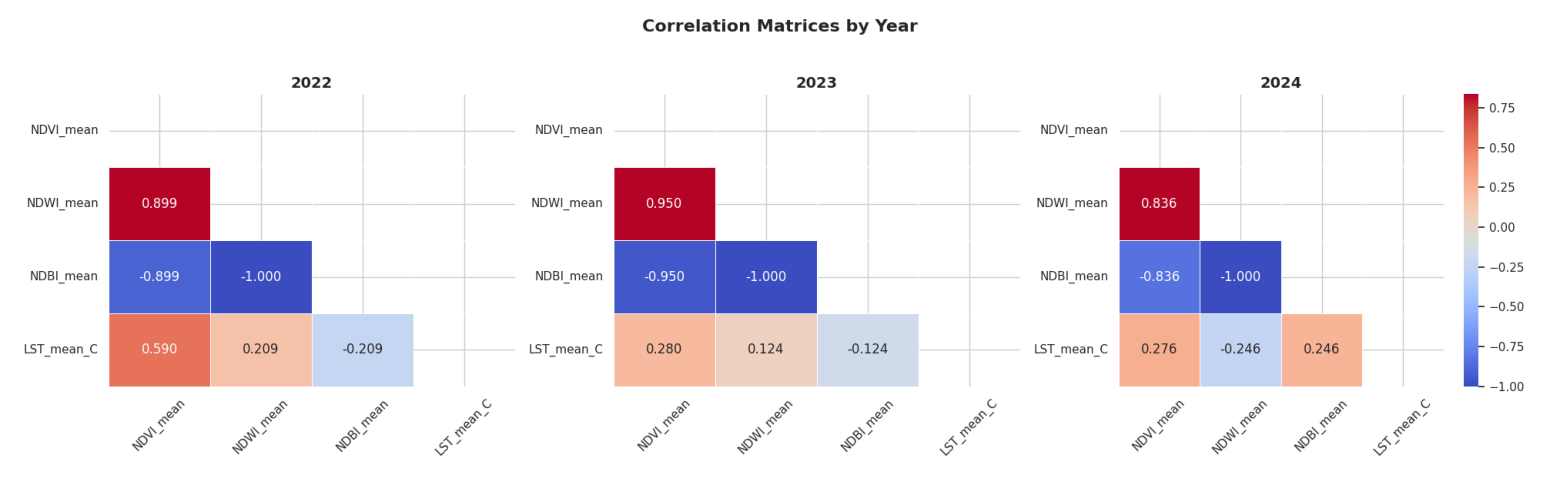

⚠️ File already exists: ../images/COMBINED_PLOTS/yearly_corr.png, displaying image.


In [24]:
# IF-ELSE: check if the image exists
if os.path.exists(YEARLY_CORRELATION_MATRIX):
    from matplotlib.image import imread
    img = imread(YEARLY_CORRELATION_MATRIX)
    plt.figure(figsize=(20, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    print(f"⚠️ File already exists: {YEARLY_CORRELATION_MATRIX}, displaying image.")
else:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

    for i, year in enumerate(years):
        df_year = df[df["year"] == year]
        corr_df = df_year[cols].corr()
        mask = np.triu(np.ones_like(corr_df, dtype=bool))  # mask upper triangle

        sns.heatmap(
            corr_df,
            mask=mask,
            annot=True,
            fmt=".3f",
            cmap="coolwarm",
            linewidths=0.5,
            linecolor="white",
            cbar=i == 2,  # show colorbar only on last plot
            ax=axes[i]
        )
        axes[i].set_title(f"{year}", fontsize=14, weight="bold")
        axes[i].tick_params(axis="x", rotation=45)
        axes[i].tick_params(axis="y", rotation=0)

    plt.suptitle("Correlation Matrices by Year", fontsize=16, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save figure
    plt.savefig(YEARLY_CORRELATION_MATRIX)
    plt.show()
    print(f"✅ Yearly correlation matrices saved at: {YEARLY_CORRELATION_MATRIX}")